In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import sys, os, sys, math
from pathlib import Path
from pprint import pprint
import matplotlib.pyplot as plt, numpy as np
from jfi import jaxm
from jfi.experimental.jit import autojit, nestedautojit

root_path = Path("").absolute().parent
if str(root_path) not in sys.path:
    sys.path.insert(0, str(root_path))
from pmpc.experimental.jax.root import (
    linearly_approximate,
    linear_optimality,
    rollout_approximate,
    masked_rollout_approximate,
    compute_sensitivity_L,
    all_sensitivity_L,
)
from pmpc.scp_mpc import solve


In [3]:
def car(x, u, p):
    """
    unicycle car dynamics, 4 states, 2 actions
    x1: position x
    x2: position y
    x3: speed (local frame)
    x4: orientation angle

    u1: acceleration
    u2: turning speed (independent of velocity)
    """
    assert x.shape[-1] == 4 and u.shape[-1] == 2
    v_scale, w_scale, T = p[..., 0], p[..., 1], p[..., 2]
    eps = 1e-6
    u1, u2 = v_scale * u[..., 0], w_scale * -u[..., 1]
    u1 = u1 + jaxm.where(u1 >= 0.0, eps, -eps)
    u2 = u2 + jaxm.where(u2 >= 0.0, eps, -eps)

    x0, y0, v0, th0 = x[..., 0], x[..., 1], x[..., 2], x[..., 3]
    xp1 = (
        x0
        + (
            u2 * jaxm.sin(T * u2 + th0) * v0
            + T * u1 * u2 * jaxm.sin(T * u2 + th0)
            + u1 * jaxm.cos(T * u2 + th0)
        )
        / u2 ** 2
        - (jaxm.sin(th0) * u2 * v0 + jaxm.cos(th0) * u1) / u2 ** 2
    )
    xp2 = (
        y0
        - (
            u2 * jaxm.cos(T * u2 + th0) * v0
            - u1 * jaxm.sin(T * u2 + th0)
            + T * u1 * u2 * jaxm.cos(T * u2 + th0)
        )
        / u2 ** 2
        + (jaxm.cos(th0) * u2 * v0 - jaxm.sin(th0) * u1) / u2 ** 2
    )
    xp3 = v0 + T * u1
    xp4 = T * u2 + th0
    xp = jaxm.stack([xp1, xp2, xp3, xp4], -1)
    return xp

def fx_(x, u, p):
    sum_dims = range(0, x.ndim - 1)
    return jaxm.moveaxis(jaxm.jacobian(lambda x: jaxm.sum(car(x, u, p), sum_dims))(x), 0, -2)

def fu_(x, u, p):
    sum_dims = range(0, x.ndim - 1)
    return jaxm.moveaxis(jaxm.jacobian(lambda u: jaxm.sum(car(x, u, p), sum_dims))(u), 0, -2)

@jaxm.jit
def f_fx_fu_fn(x, u, p = None):
    if p is None:
        p = jaxm.to(jaxm.array([1.0, 1.0, 0.3]), dtype=x.dtype)
    return car(x, u, p), fx_(x, u, p), fu_(x, u, p)

In [4]:
N, xdim, udim = 20, 4, 2

Q = np.tile(np.eye(xdim), (N, 1, 1))
R = np.tile(1e-2 * np.eye(udim), (N, 1, 1))
x0 = np.tile(np.ones(xdim), (1,))
X_ref, U_ref = np.zeros((N, xdim)), np.zeros((N, udim))
X_prev, U_prev = np.zeros((N, xdim)), np.zeros((N, udim))
u_lim = 1e0
u_l, u_u = -u_lim * np.ones((N, udim)), u_lim * np.ones((N, udim))

problem = dict(
    f_fx_fu_fn=f_fx_fu_fn,
    Q=Q,
    R=R,
    x0=x0,
    X_ref=X_ref,
    U_ref=U_ref,
    X_prev=X_prev,
    U_prev=U_prev,
    u_l=u_l,
    u_u=u_u,
    solver_settings=dict(smooth_alpha=1e-1, solver="ecos"),
    reg_x=1e0,
    reg_u=1e0,
    max_it=20,
    res_tol=1e-12,
    verbose=True,
    slew_rate=1e2,
    P=1.0 * jaxm.ones((N,)),
)

In [5]:
X, U, _ = solve(**dict(problem, f_fx_fu_fn=lambda x, u: f_fx_fu_fn(x, u, p=problem["P"])))

+------+------------+------------+------------+------------+------------+
|  it  |   elaps    |    obj     |   resid    |   reg_x    |   reg_u    |
+------+------------+------------+------------+------------+------------+
| 0001 |  2.146e+01 |  2.754e+00 |  2.269e+00 |  1.000e+00 |  1.000e+00 |
| 0002 |  2.198e+01 |  1.867e+00 |  6.872e-01 |  1.000e+00 |  1.000e+00 |
| 0003 |  2.248e+01 |  1.595e+00 |  3.601e-01 |  1.000e+00 |  1.000e+00 |
| 0004 |  2.289e+01 |  1.507e+00 |  1.984e-01 |  1.000e+00 |  1.000e+00 |
| 0005 |  2.333e+01 |  1.481e+00 |  1.050e-01 |  1.000e+00 |  1.000e+00 |
| 0006 |  2.374e+01 |  1.474e+00 |  5.603e-02 |  1.000e+00 |  1.000e+00 |
| 0007 |  2.426e+01 |  1.472e+00 |  2.989e-02 |  1.000e+00 |  1.000e+00 |
| 0008 |  2.459e+01 |  1.472e+00 |  1.595e-02 |  1.000e+00 |  1.000e+00 |
| 0009 |  2.482e+01 |  1.472e+00 |  8.539e-03 |  1.000e+00 |  1.000e+00 |
| 0010 |  2.504e+01 |  1.472e+00 |  4.583e-03 |  1.000e+00 |  1.000e+00 |
| 0011 |  2.529e+01 |  1.472e+00 |  2.

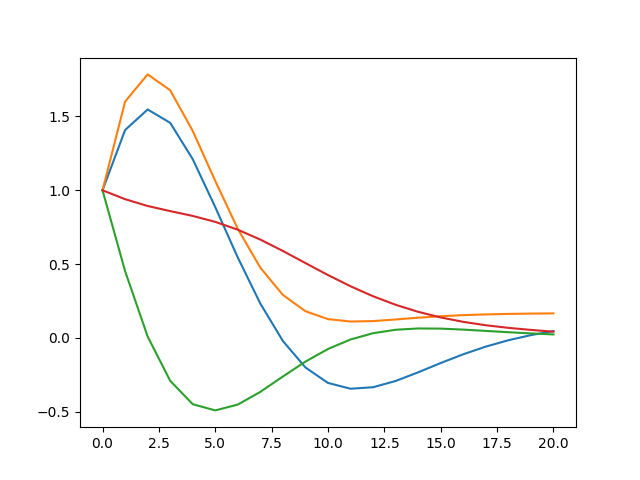

In [6]:
plt.figure()
for i in range(X.shape[-1]):
    plt.plot(X[:, i])
plt.show()

In [10]:
import time
t = time.time()
Ls = all_sensitivity_L(X, U, problem)
print(f"{time.time() - t:.4e}")

9.4398e+00


In [11]:
xs = []
x = 1e-1 * jaxm.randn((xdim,)) + problem["x0"]
xs.append(x)
for i in range(U.shape[-2]):
    u = U[i, :]
    x = problem["f_fx_fu_fn"](x, u, problem["P"])[0]
    xs.append(x)
X_actual = jaxm.stack(xs, 0)

x = xs[0]
xs = []
xs.append(x)
for i in range(U.shape[-2]):
    u = U[i, :] + Ls[0, :, :] @ (x - X[i, :])
    x = problem["f_fx_fu_fn"](x, u, problem["P"])[0]
    xs.append(x)
X_feedback = jaxm.stack(xs, 0)

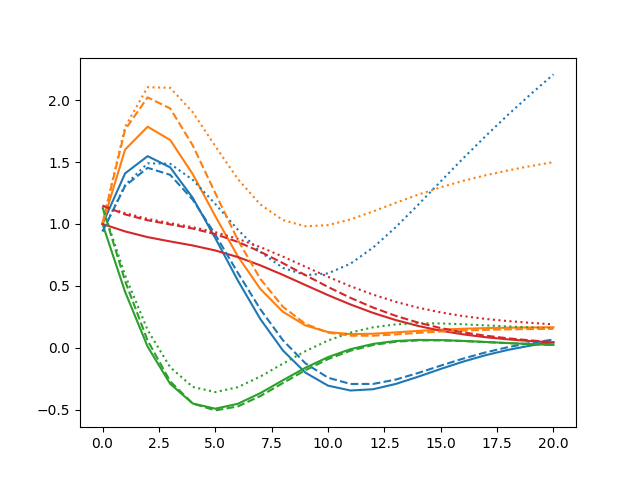

In [13]:
plt.figure()
for i in range(X.shape[-1]):
    plt.plot(X[:, i], color=f"C{i}", linestyle="-")
for i in range(X_actual.shape[-1]):
    plt.plot(X_actual[:, i], color=f"C{i}", linestyle=":")
for i in range(X_feedback.shape[-1]):
    plt.plot(X_feedback[:, i], color=f"C{i}", linestyle="--")
plt.show()

# Test consensus optmization

In [13]:
M, N, xdim, udim = 20, 20, 4, 2

Q = np.tile(np.eye(xdim), (N, 1, 1))
R = np.tile(1e-2 * np.eye(udim), (N, 1, 1))
x0 = np.tile(np.ones(xdim), (1,))
X_ref, U_ref = np.zeros((N, xdim)), np.zeros((N, udim))
X_prev, U_prev = np.zeros((N, xdim)), np.zeros((N, udim))
u_lim = 1e0
u_l, u_u = -u_lim * np.ones((N, udim)), u_lim * np.ones((N, udim))

Q, R, x0, X_ref, U_ref, X_prev, U_prev, u_l, u_u = [
    jaxm.tile(z, (M,) + (1,) * z.ndim) for z in [Q, R, x0, X_ref, U_ref, X_prev, U_prev, u_l, u_u]
]
P = jaxm.linspace(0.7, 1.0, M)
P = (jaxm.ones((1, N)) * P[:, None])[..., None]
assert P.shape == (M, N, 1)

problem = dict(
    f_fx_fu_fn=lambda x, u: f_fx_fu_fn(x, u, p=P),
    Q=Q,
    R=R,
    x0=x0,
    X_ref=X_ref,
    U_ref=U_ref,
    X_prev=X_prev,
    U_prev=U_prev,
    u_l=u_l,
    u_u=u_u,
    solver_settings=dict(Nc=5, solver="jump", smooth_alpha=1e0),
    reg_x=1e0,
    reg_u=1e0,
    max_it=50,
    res_tol=1e-5,
    verbose=True,
    slew_rate=1e2,
    P=P,
)

In [15]:
X, U, data = solve(**problem)

+------+------------+------------+------------+------------+------------+
|  it  |   elaps    |    obj     |   resid    |   reg_x    |   reg_u    |
+------+------------+------------+------------+------------+------------+
| 0001 |  1.971e-01 |  3.000e+00 |  2.523e+00 |  1.000e+00 |  1.000e+00 |
| 0002 |  4.190e-01 |  2.473e+00 |  9.595e-01 |  1.000e+00 |  1.000e+00 |
| 0003 |  6.178e-01 |  2.177e+00 |  6.920e-01 |  1.000e+00 |  1.000e+00 |
| 0004 |  7.994e-01 |  2.063e+00 |  3.792e-01 |  1.000e+00 |  1.000e+00 |
| 0005 |  9.847e-01 |  2.026e+00 |  2.060e-01 |  1.000e+00 |  1.000e+00 |
| 0006 |  1.213e+00 |  2.013e+00 |  1.168e-01 |  1.000e+00 |  1.000e+00 |
| 0007 |  1.396e+00 |  2.008e+00 |  6.618e-02 |  1.000e+00 |  1.000e+00 |
| 0008 |  1.582e+00 |  2.006e+00 |  3.749e-02 |  1.000e+00 |  1.000e+00 |
| 0009 |  1.794e+00 |  2.006e+00 |  2.124e-02 |  1.000e+00 |  1.000e+00 |
| 0010 |  1.980e+00 |  2.005e+00 |  1.203e-02 |  1.000e+00 |  1.000e+00 |
| 0011 |  2.174e+00 |  2.005e+00 |  6.

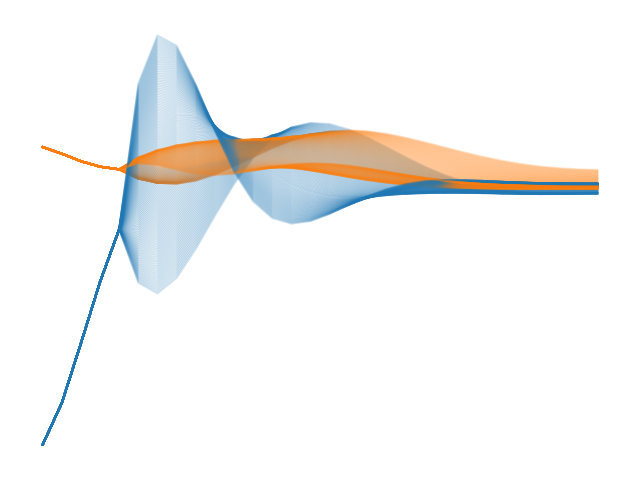

In [17]:
plt.figure()
for j in range(U.shape[0]):
    for i in range(U.shape[-1]):
        plt.plot(U[j, :, i], color=f"C{i}", alpha=0.2)
plt.axis("off")
plt.tight_layout()
plt.savefig("controls.svg")
plt.show()

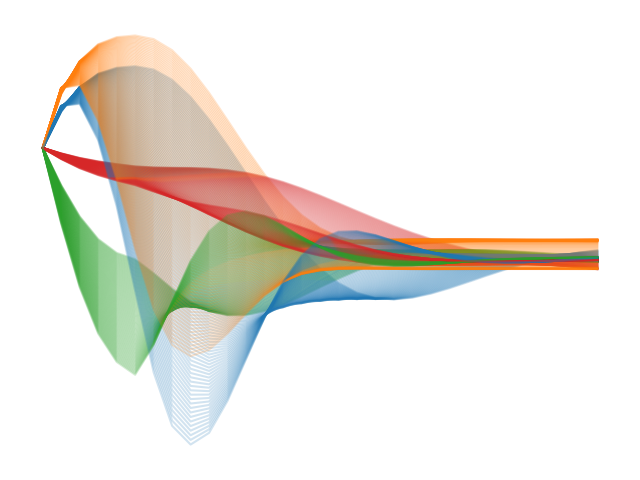

In [18]:
plt.figure()
for j in range(X.shape[0]):
    for i in range(X.shape[-1]):
        plt.plot(X[j, :, i], color=f"C{i}", alpha=0.2)
plt.axis("off")
plt.tight_layout()
plt.savefig("states.svg")
plt.show()